After nominal pass:
- Determine optimal #HCP from nominal associations
- Visualize expression regressed by covariates, check batch effect
- Maybe: Relative log-expression RLE plots

After permutation pass:
- check beta approximated permutation pval
- QTL TSS distance density plot
- Compare sig feature across ancestries, upsetR
- Venn graph for fetal vs PEC, GTEx
- Conditional pass

In [1]:
library(ggplot2)
library(data.table)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### 1: Optimal number of HCP

#### Mixed ancestry

In [2]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_nominal_", i, 
                                           "hcp/significant_feature_count.txt"))[,1]
}

In [3]:
df

HCP,Count
<dbl>,<int>
10,19669
20,21267
30,21839
40,22320
50,22648
60,22671
70,22736
80,22830
90,22850


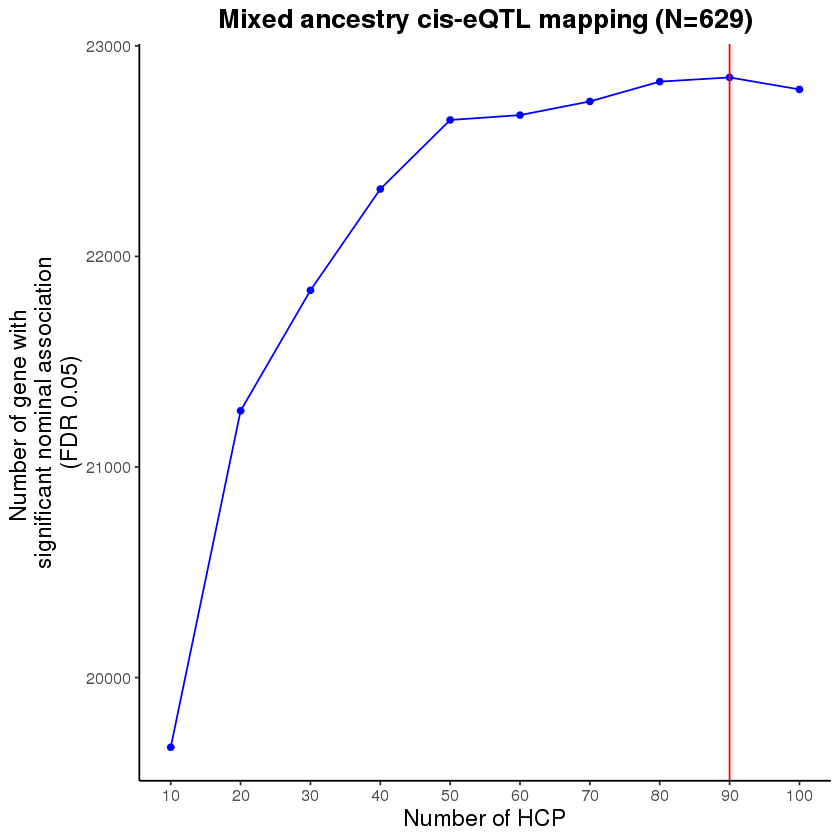

In [4]:
p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 90, color = "red") +
    labs(title = "Mixed ancestry cis-eQTL mapping (N=629)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p1

In [5]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/mixed_nominal.png", p1, width = 6, height = 6)

#### EUR

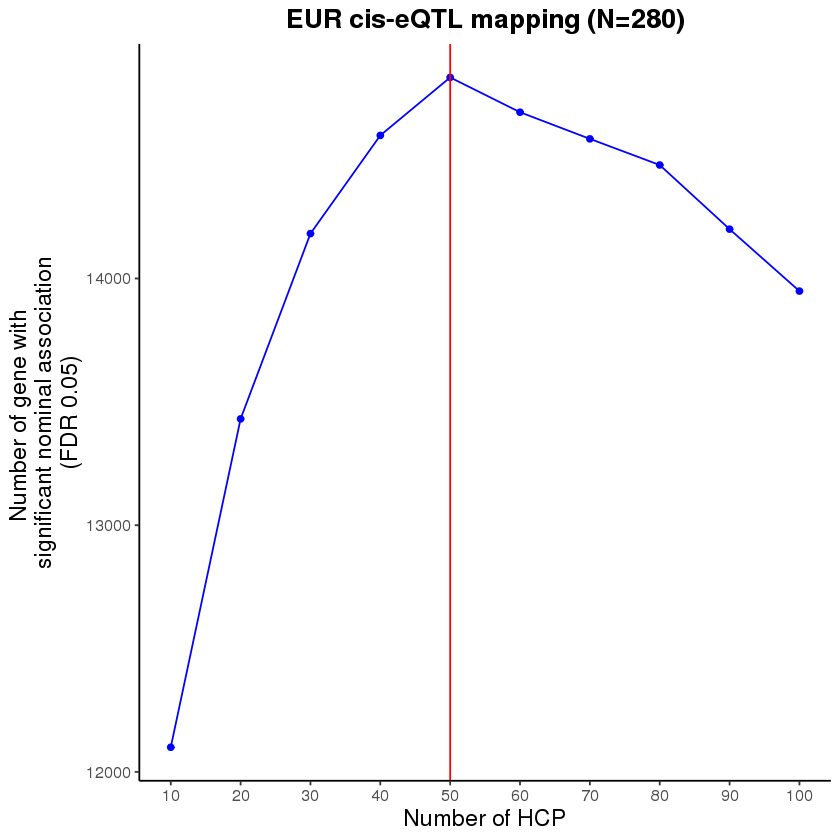

In [2]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("~/project-gandalm/isoform_twas/eqtl_new/results/eur_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p3 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 50, color = "red") +
    labs(title = "EUR cis-eQTL mapping (N=280)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p3

In [3]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/eur_nominal.png", p3, width = 6, height = 6)

#### AMR

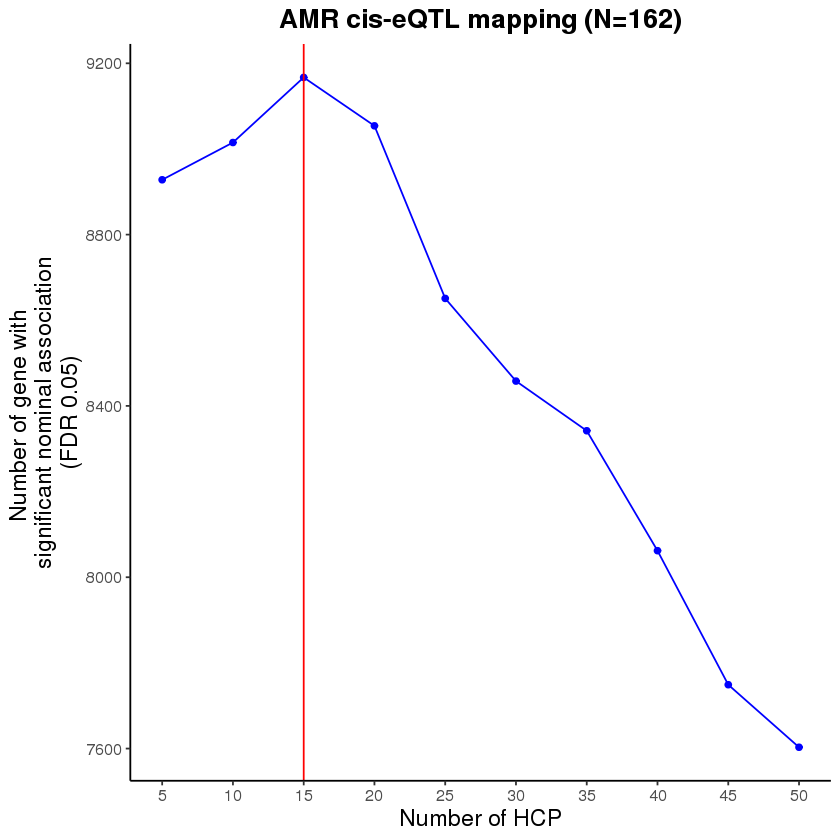

In [4]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("~/project-gandalm/isoform_twas/eqtl_new/results/amr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p4 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 15, color = "red") +
    labs(title = "AMR cis-eQTL mapping (N=162)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p4

In [5]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/amr_nominal.png", p4, width = 6, height = 6)

#### AFR

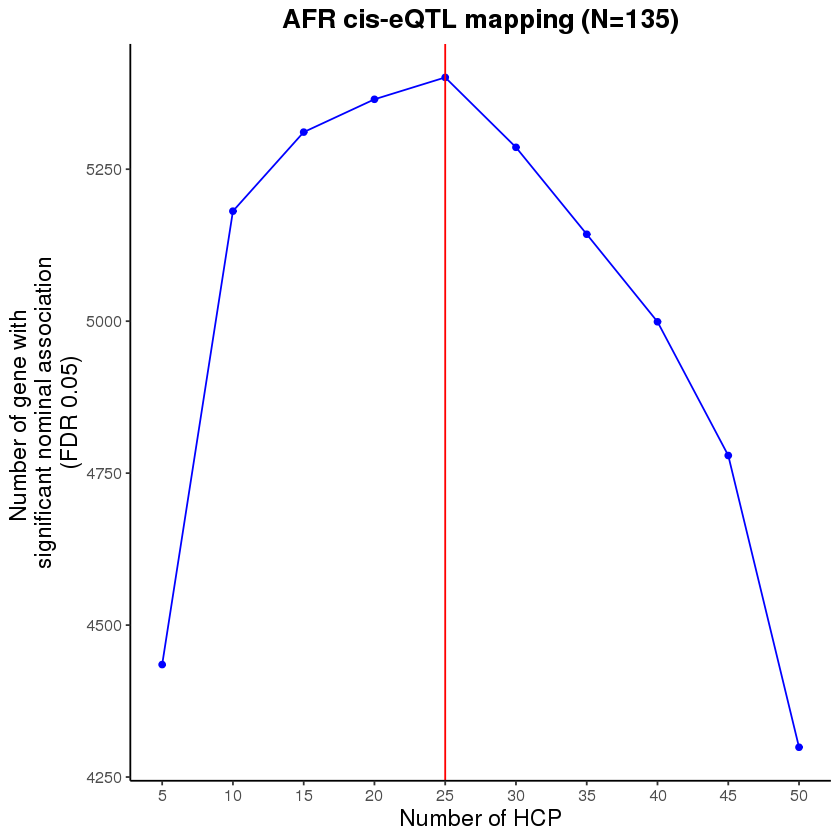

In [7]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("~/project-gandalm/isoform_twas/eqtl_new/results/afr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p5 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 25, color = "red") +
    labs(title = "AFR cis-eQTL mapping (N=135)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p5

In [8]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/afr_nominal.png", p5, width = 6, height = 6)

### 2: Gene expression regression, check batch effects

#### Mixed ancestry

In [6]:
datExpr <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [7]:
datExpr_noCombat <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.noComBat.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [8]:
cov <- read.table("~/project-gandalm/isoform_twas/eqtl_new/data/90hcp_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

In [9]:
# remove related
rel <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/related.txt", header = F, stringsAsFactors = F)[,1]
rel

[1] "1614"   "11602"  "Br1779" "Br2394" "Br2402" "Br2411" "Br2412" "1713"  
 [9] "11841"  "Br1794" "HSB148" "HSB107" "HSB154" "HSB100"

In [10]:
head(cov)

,1474,1496,1500,1502,1507,1511,1513,1525,1531,1533,⋯,1558,1607,1707.1,1835,1851,1890,1923,2193,849,898
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PC1,0.00898199,-0.0076338,0.0111147,0.00487142,0.00960893,-0.01488,0.00883737,-0.0266981,-0.0253829,0.00976202,⋯,0.00967447,-0.0252683,0.00965381,0.00960237,0.00979039,0.00950035,0.00960529,0.00989866,0.00702467,0.00983834
PC2,-0.00035727,-0.000843408,-0.0158545,0.000257063,-0.00326613,-0.00113582,-0.00241496,-0.0022033,-0.00247448,-0.0043343,⋯,-0.0208489,-0.00395539,-0.0206395,-0.0210822,-0.0204132,-0.0205727,-0.0206059,-0.0210826,0.0245783,-0.0205709
PC3,-0.0248268,-0.0141886,-0.0101601,-0.0222758,-0.020871,-0.00907471,-0.021557,-0.00118133,-0.00152521,-0.0192131,⋯,-0.00482939,-0.00111922,-0.00453659,-0.00526304,-0.00508921,-0.00534413,-0.00518309,-0.00544843,-0.00538244,-0.00537699
PC4,-0.0321383,-0.0175555,-0.000733046,-0.0315899,-0.0245335,-0.0106596,-0.0266302,0.000414128,0.000549499,-0.0225191,⋯,0.0229196,0.0138587,0.0222114,0.0226635,0.0214958,0.0226123,0.0221212,0.0239712,0.0252937,0.0216689
PC5,0.000571238,-0.00167298,-0.0126722,0.00128243,-0.00225702,-0.00145859,-0.00174134,-0.00474446,-0.00445944,-0.0030688,⋯,0.0685564,0.0750816,0.0672512,0.0693604,0.0685406,0.06972,0.0690513,0.0679772,0.0693614,0.0681412
sex,M,F,M,M,M,M,M,M,F,M,⋯,F,F,F,M,F,F,F,M,F,F


In [12]:
cov <- cov[,!names(cov) %in% rel]
dim(cov)

[1]  97 629

In [14]:
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

[1] 31947   629

[1] 31947   629

In [15]:
cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

In [16]:
cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

In [17]:
walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

In [18]:
# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

In [19]:
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

In [20]:
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

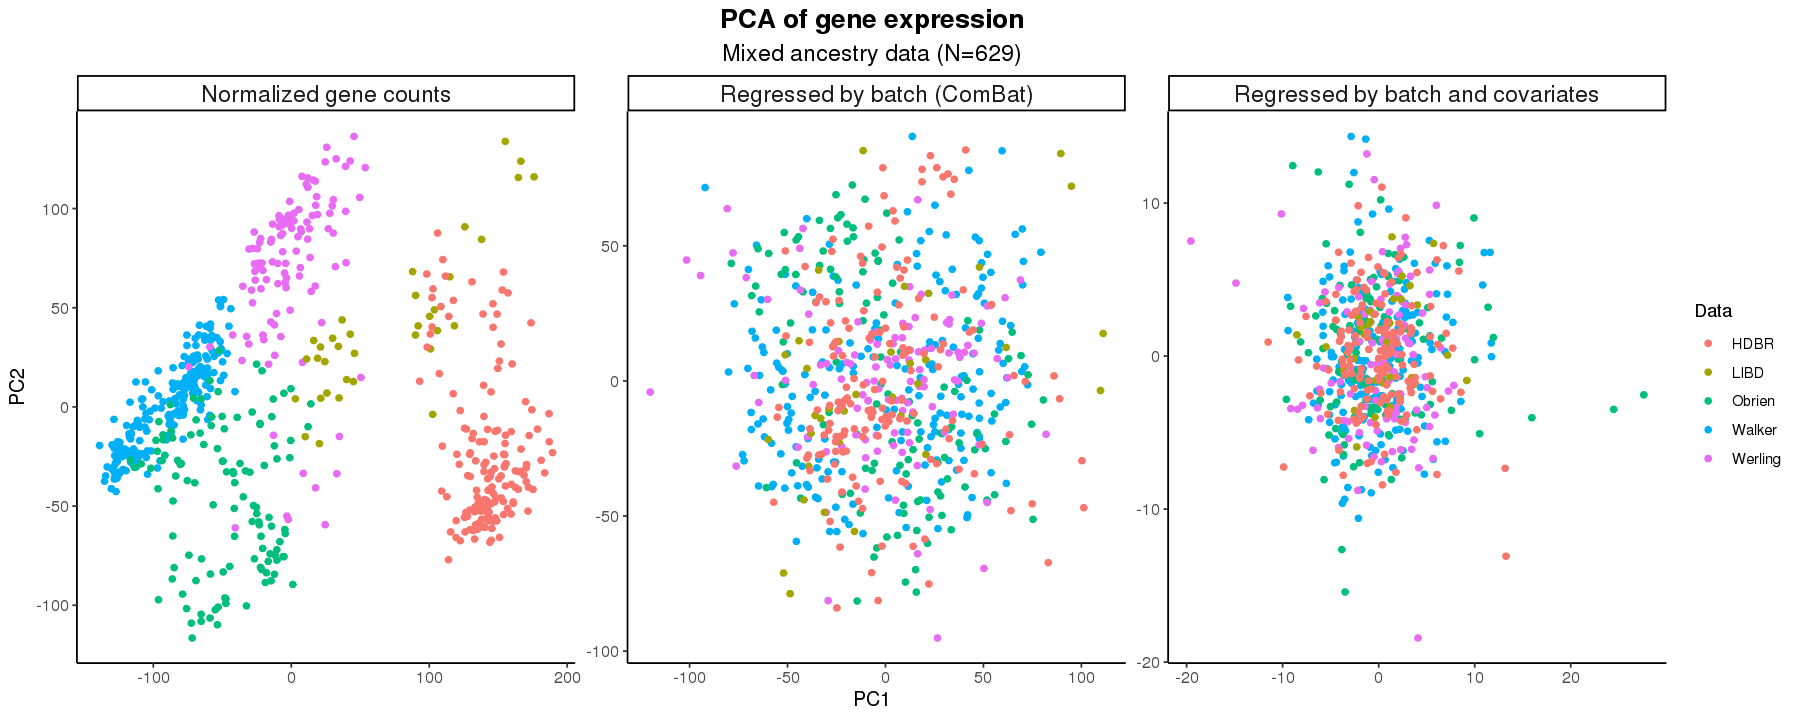

In [21]:
options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p2 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "Mixed ancestry data (N=629)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p2

In [22]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/mixed_regress.png", p2, width = 15, height = 6)

#### EUR

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.tsv", :
“Detected 284 column names but the data has 285 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.noComBat.tsv", :
“Detected 284 column names but the data has 285 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  57 280

[1] 31947   280

[1] 31947   280

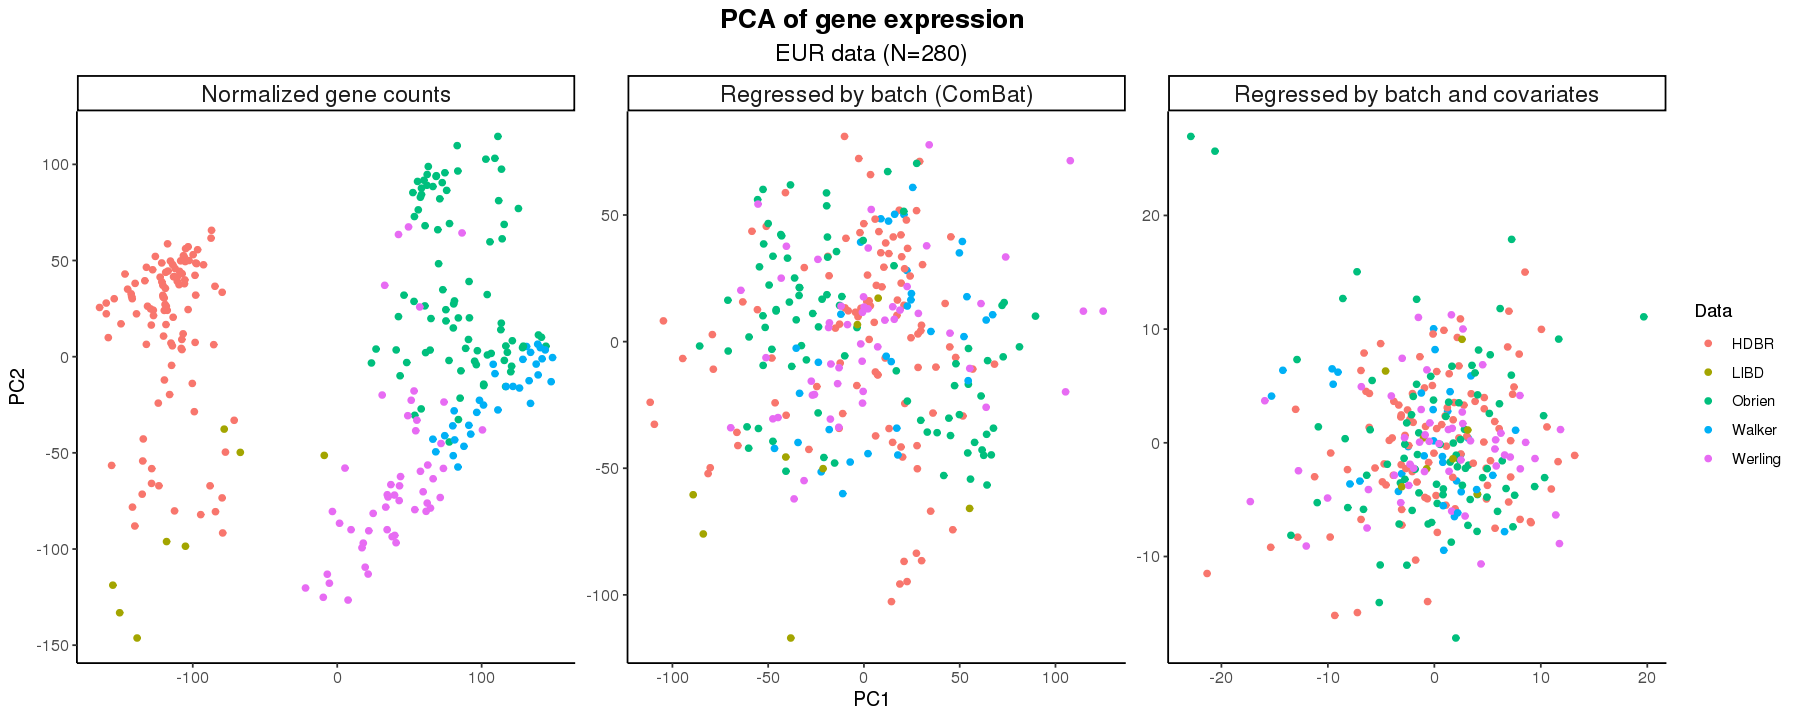

In [10]:
datExpr <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("~/project-gandalm/isoform_twas/eqtl_new/data/eur/50HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p6 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "EUR data (N=280)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p6

In [11]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/eur_regress.png", p6, width = 15, height = 6)

#### AMR

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.noComBat.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  22 162

[1] 31947   162

[1] 31947   162

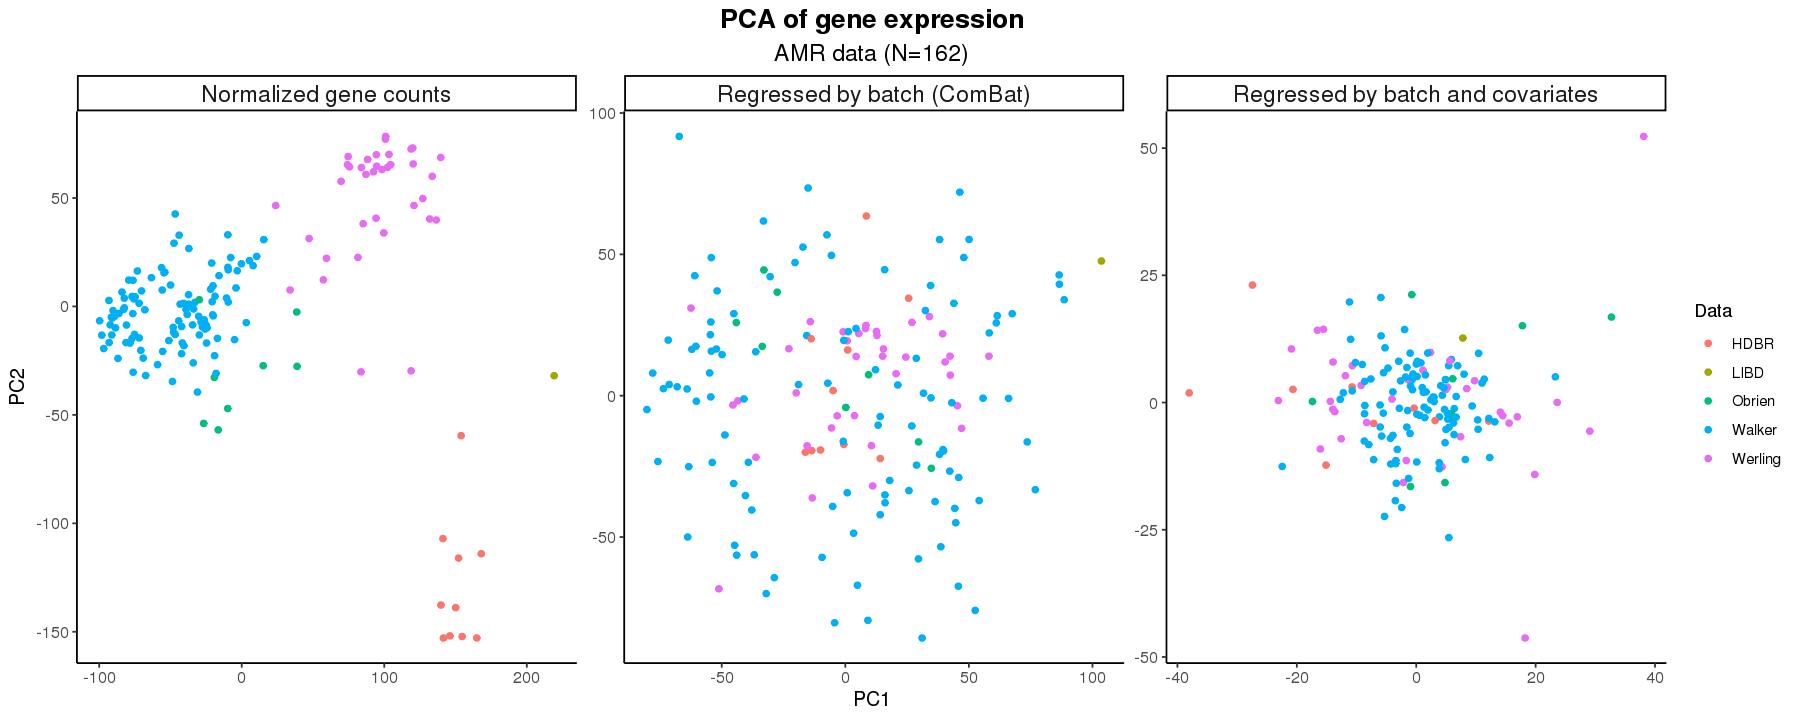

In [13]:
datExpr <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("~/project-gandalm/isoform_twas/eqtl_new/data/amr/15HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

# walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
# obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
# werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
# hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
# libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p7 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "AMR data (N=162)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p7

ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/amr_regress.png", p7, width = 15, height = 6)

#### AFR

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.tsv", :
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.noComBat.tsv", :
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  32 135

[1] 31947   135

[1] 31947   135

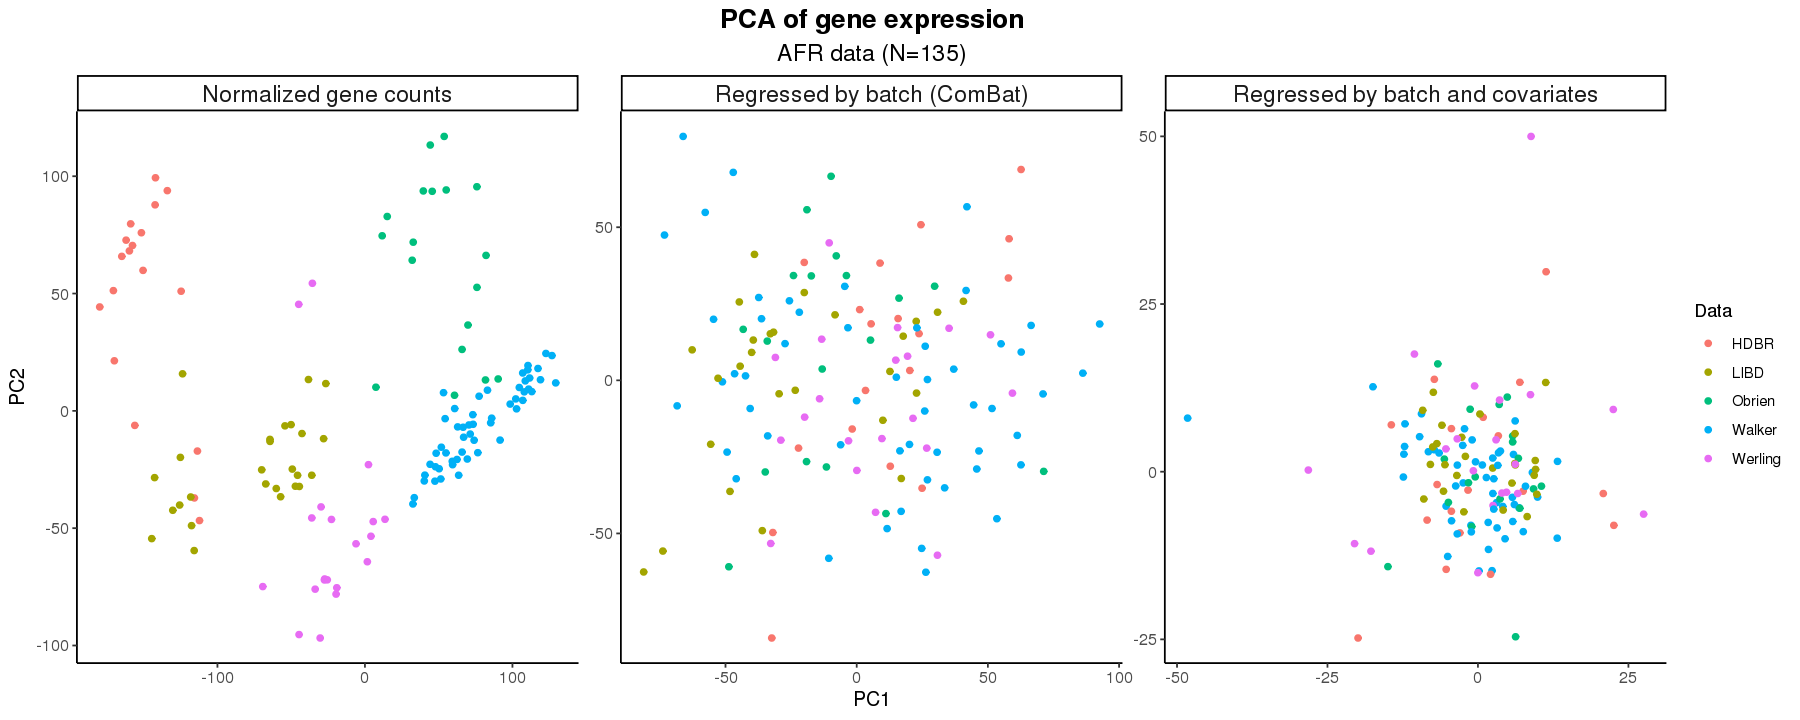

In [14]:
datExpr <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("~/project-gandalm/isoform_twas/eqtl_new/data/afr/25HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

# walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
# obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
# werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
# hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
# libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p8 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "AFR data (N=135)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p8

ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/afr_regress.png", p8, width = 15, height = 6)

### 3: Check beta-approximated permutation pval

In [5]:
mixed <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_perm_90hcp/all.chunks.txt.gz", data.table=F)
colnames(mixed) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")

Warning message:
“Removed 416 rows containing missing values (geom_point).”


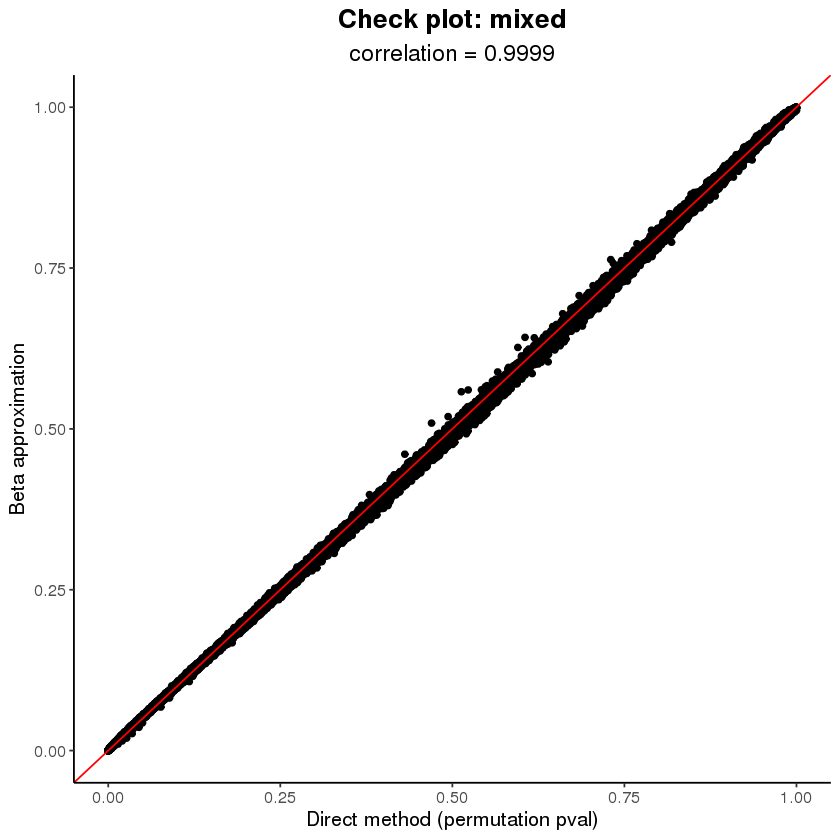

In [11]:
p <- ggplot(mixed, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: mixed",
         subtitle = "correlation = 0.9999") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [17]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/mixed_check.png", p, width = 6, height = 6)

Warning message:
“Removed 416 rows containing missing values (geom_point).”


Warning message:
“Removed 416 rows containing missing values (geom_point).”
Warning message:
“Removed 416 rows containing missing values (geom_point).”


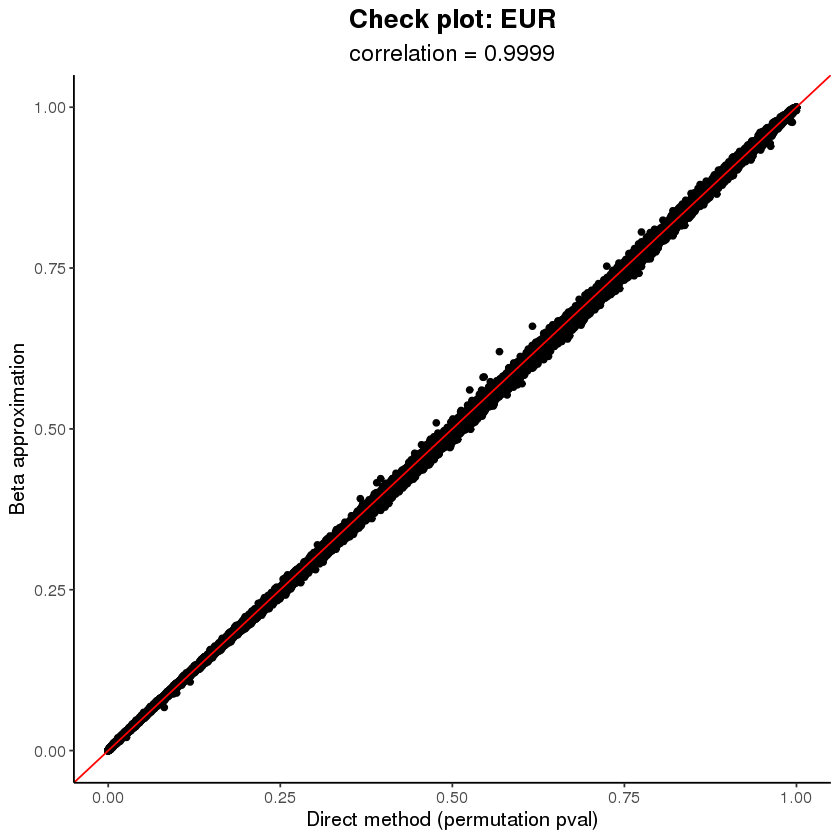

In [18]:
eur <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/eur_perm_50HCP/all.chunks.txt.gz", data.table=F)
colnames(eur) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
p1 <- ggplot(eur, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: EUR",
         subtitle = "correlation = 0.9999") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p1
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/eur_check.png", p1, width = 6, height = 6)

Warning message:
“Removed 416 rows containing missing values (geom_point).”
Warning message:
“Removed 416 rows containing missing values (geom_point).”


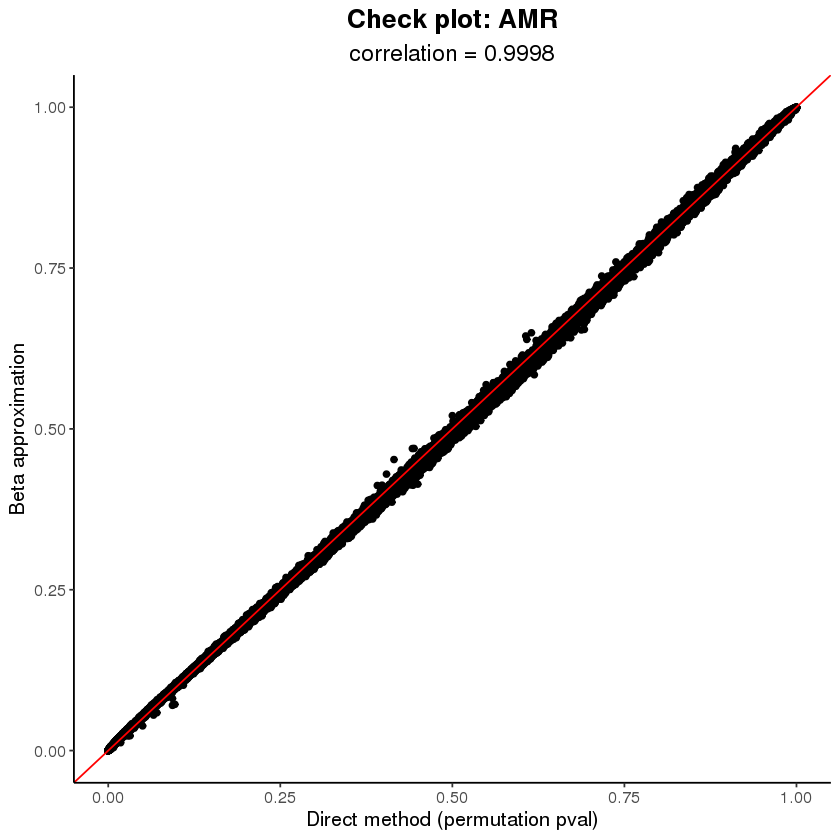

In [20]:
amr <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/amr_perm_15HCP/all.chunks.txt.gz", data.table=F)
colnames(amr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
p2 <- ggplot(amr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AMR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p2
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/amr_check.png", p2, width = 6, height = 6)

Warning message:
“Removed 416 rows containing missing values (geom_point).”
Warning message:
“Removed 416 rows containing missing values (geom_point).”


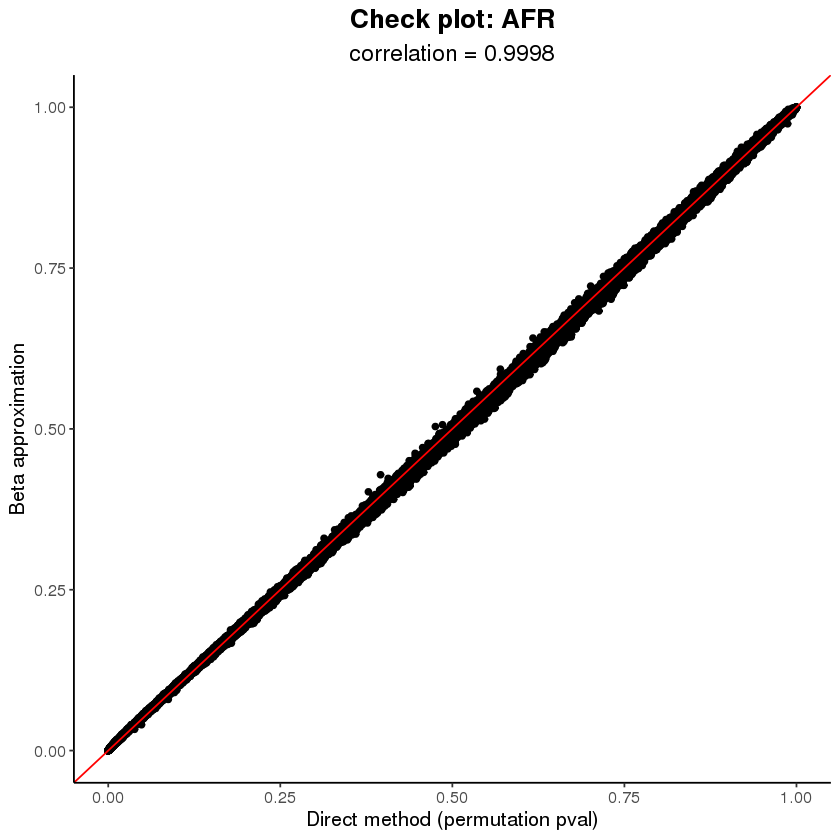

In [21]:
afr <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/afr_perm_20HCP/all.chunks.txt.gz", data.table=F)
colnames(afr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
p3 <- ggplot(afr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AFR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p3
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/afr_check.png", p3, width = 6, height = 6)

### 4: dTSS of top eQTL

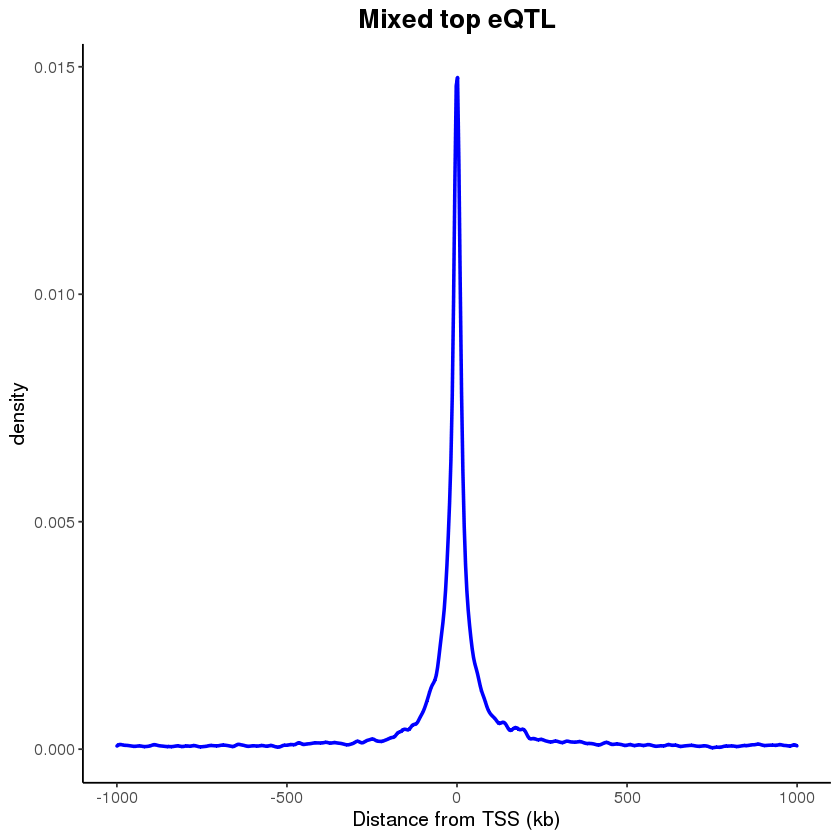

In [2]:
mixed_sig <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_perm_90hcp/sig_pheno.txt", header = T, stringsAsFactors = F)
mixed_sig$dist_kb <- mixed_sig$dist/1000
p <- ggplot(mixed_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "Mixed top eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [36]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/mixed_dist.png", p, height = 6, width = 6)

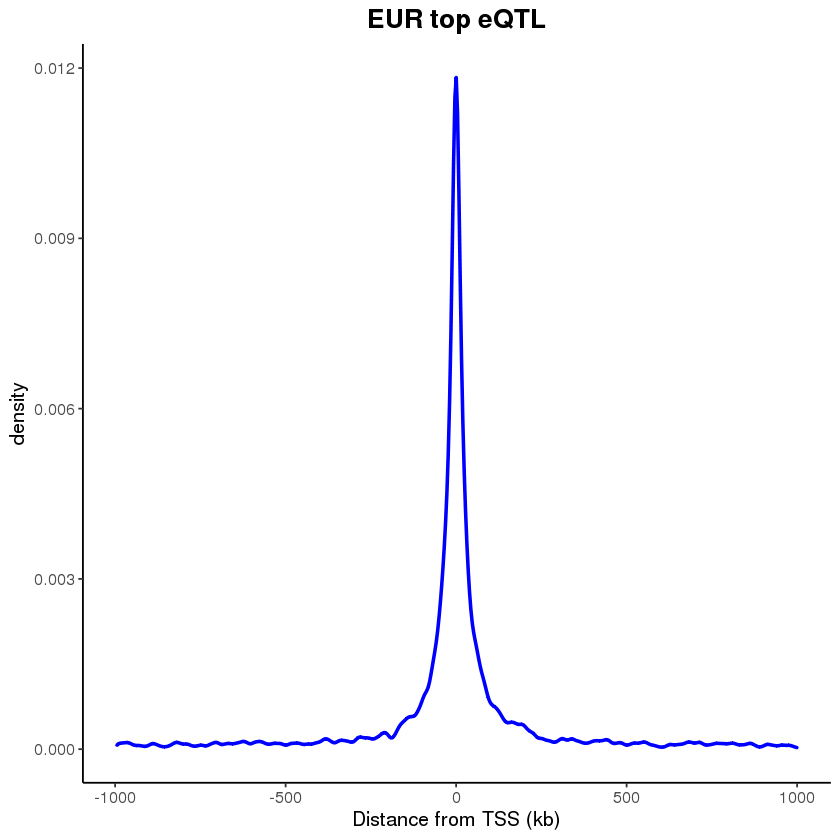

In [37]:
eur_sig <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/eur_perm_50HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
eur_sig$dist_kb <- eur_sig$dist/1000
p1 <- ggplot(eur_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "EUR top eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p1
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/eur_dist.png", p1, height = 6, width = 6)

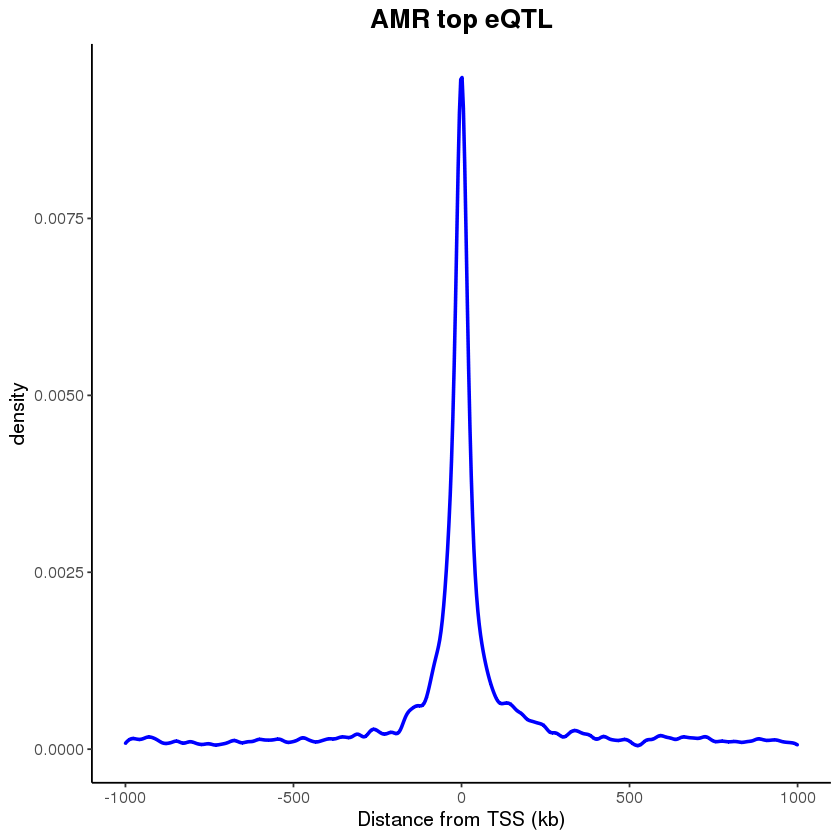

In [38]:
amr_sig <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/amr_perm_15HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
amr_sig$dist_kb <- amr_sig$dist/1000
p2 <- ggplot(amr_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "AMR top eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p2
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/amr_dist.png", p2, height = 6, width = 6)

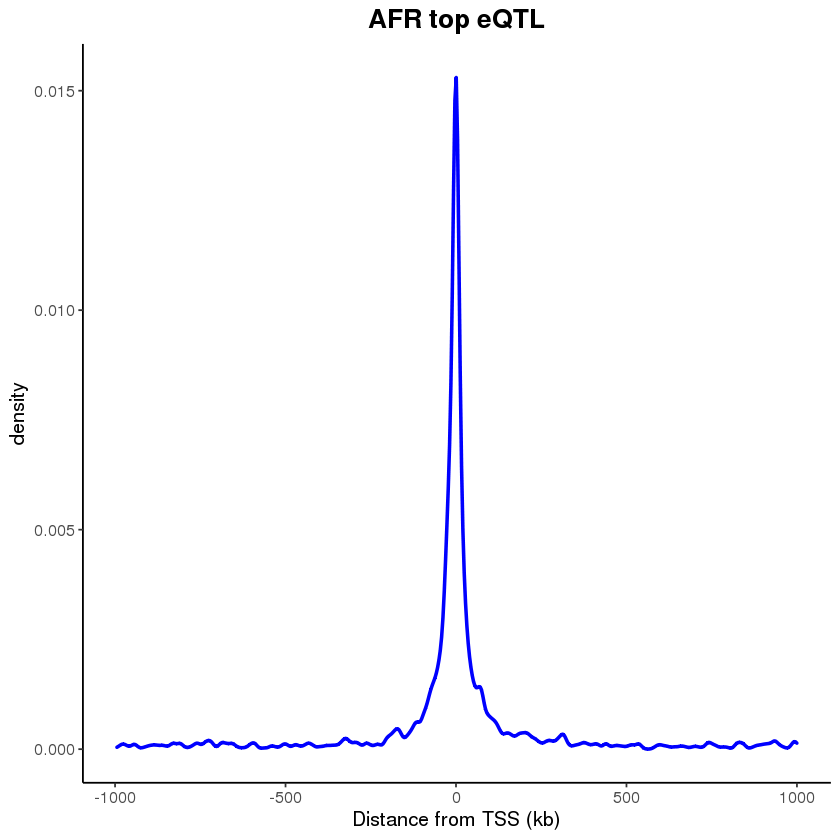

In [39]:
afr_sig <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/afr_perm_20HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
afr_sig$dist_kb <- afr_sig$dist/1000
p3 <- ggplot(afr_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "AFR top eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p3
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/afr_dist.png", p3, height = 6, width = 6)

### 5: Ancestry eGene UpsetR

In [40]:
mixed_gene <- unique(mixed_sig$pid)
eur_gene <- unique(eur_sig$pid)
amr_gene <- unique(amr_sig$pid)
afr_gene <- unique(afr_sig$pid)

In [41]:
genes <- list(Mixed = mixed_gene,
            EUR = eur_gene,
            AMR = amr_gene,
            AFR = afr_gene)

In [31]:
library(UpSetR)

In [42]:
pdf(file="~/project-gandalm/isoform_twas/eqtl_new/figures/upsetr_egene.pdf", onefile=F)
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of eGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Mixed"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Mixed"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1))
dev.off()

png 
  2

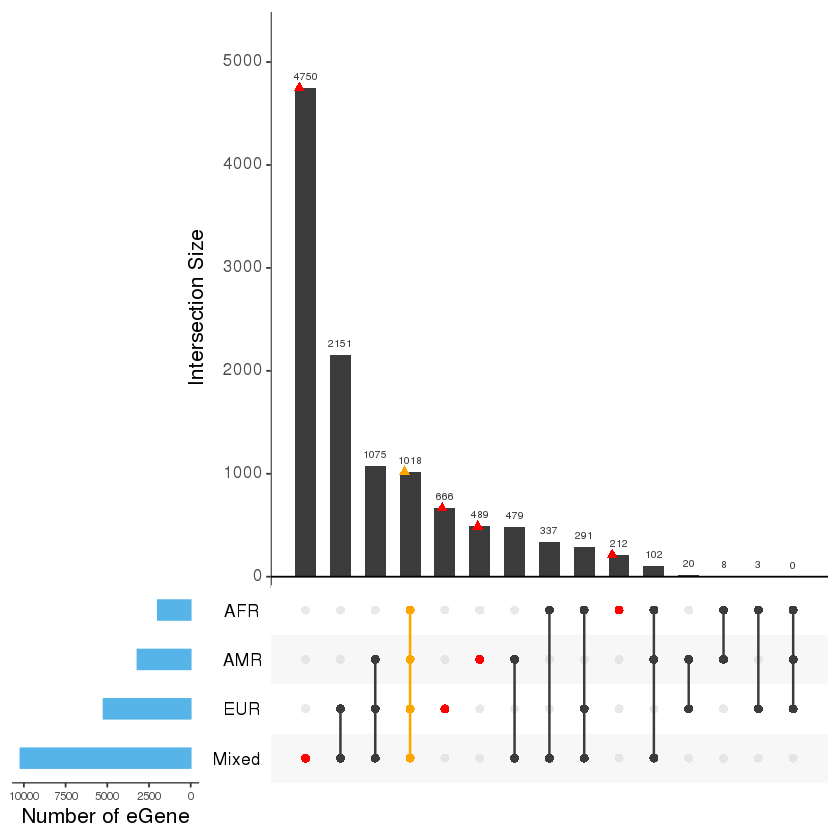

In [43]:
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of eGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Mixed"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Mixed"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1))

### 6: eGene venn PsychENCODE, GTEx cortex

### 7: eGene types

In [4]:
annot <- fread("~/project-gandalm/isoform_twas/salmon/gencode.v33lift37.annotation.gene.info.tsv", data.table=F)

In [5]:
head(annot)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,ensg,version,V11,V12
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5_2""; gene_type ""transcribed_unprocessed_pseudogene""; gene_name ""DDX11L1""; level 2; hgnc_id ""HGNC:37102""; havana_gene ""OTTHUMG00000000961.2_2""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000223972,5_2,transcribed_unprocessed_pseudogene,DDX11L1
2,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5_3""; gene_type ""unprocessed_pseudogene""; gene_name ""WASH7P""; level 2; hgnc_id ""HGNC:38034""; havana_gene ""OTTHUMG00000000958.1_3""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000227232,5_3,unprocessed_pseudogene,WASH7P
3,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5_6""; gene_type ""lncRNA""; gene_name ""MIR1302-2HG""; level 2; hgnc_id ""HGNC:52482""; tag ""ncRNA_host""; havana_gene ""OTTHUMG00000000959.2_6""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000243485,5_6,lncRNA,MIR1302-2HG
4,chr1,HAVANA,gene,34554,36081,.,-,.,"gene_id ""ENSG00000237613.2_4""; gene_type ""lncRNA""; gene_name ""FAM138A""; level 2; hgnc_id ""HGNC:32334""; havana_gene ""OTTHUMG00000000960.1_4""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000237613,2_4,lncRNA,FAM138A
5,chr1,HAVANA,gene,52473,53312,.,+,.,"gene_id ""ENSG00000268020.3_4""; gene_type ""unprocessed_pseudogene""; gene_name ""OR4G4P""; level 2; hgnc_id ""HGNC:14822""; havana_gene ""OTTHUMG00000185779.1_4""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000268020,3_4,unprocessed_pseudogene,OR4G4P
6,chr1,HAVANA,gene,57598,64116,.,+,.,"gene_id ""ENSG00000240361.2_3""; gene_type ""transcribed_unprocessed_pseudogene""; gene_name ""OR4G11P""; level 2; hgnc_id ""HGNC:31276""; havana_gene ""OTTHUMG00000001095.3_3""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000240361,2_3,transcribed_unprocessed_pseudogene,OR4G11P


In [9]:
mixed_sig <- mixed_sig %>% left_join(annot, by=c("pid"="ensg"))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [10]:
head(mixed_sig)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,⋯,V3,V4,V5,V6,V7,V8,V9,version,V11,V12
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000000419,6979,1.04952,1264.930,481.647,rs192563417,785096,2.38905e-09,-0.5619380,0.00009999,⋯,gene,49551404,49575092,.,-,.,"gene_id ""ENSG00000000419.12_5""; gene_type ""protein_coding""; gene_name ""DPM1""; level 2; hgnc_id ""HGNC:3005""; havana_gene ""OTTHUMG00000032742.2_5""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",12_5,protein_coding,DPM1
2,ENSG00000000460,7370,1.03778,717.486,475.523,rs17529513,167500,4.67354e-22,-0.2929770,0.00009999,⋯,gene,169631245,169823221,.,+,.,"gene_id ""ENSG00000000460.17_6""; gene_type ""protein_coding""; gene_name ""C1orf112""; level 2; hgnc_id ""HGNC:25565""; havana_gene ""OTTHUMG00000035821.9_6""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",17_6,protein_coding,C1orf112
3,ENSG00000001036,5683,1.03195,875.543,474.568,rs4896658,-47658,2.59654e-07,-0.5777090,0.00109989,⋯,gene,143815949,143832857,.,-,.,"gene_id ""ENSG00000001036.14_4""; gene_type ""protein_coding""; gene_name ""FUCA2""; level 2; hgnc_id ""HGNC:4008""; havana_gene ""OTTHUMG00000015728.3_4""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",14_4,protein_coding,FUCA2
4,ENSG00000001167,6760,1.02224,1240.200,493.565,rs10456503,247271,1.27215e-05,0.0637818,0.03379660,⋯,gene,41040684,41067715,.,+,.,"gene_id ""ENSG00000001167.14_3""; gene_type ""protein_coding""; gene_name ""NFYA""; level 2; hgnc_id ""HGNC:7804""; havana_gene ""OTTHUMG00000014669.1_3""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",14_3,protein_coding,NFYA
5,ENSG00000001460,5648,1.03560,824.541,474.263,rs760969,2280,5.68767e-64,-0.6619200,0.00009999,⋯,gene,24683489,24743424,.,-,.,"gene_id ""ENSG00000001460.18_6""; gene_type ""protein_coding""; gene_name ""STPG1""; level 2; hgnc_id ""HGNC:28070""; havana_gene ""OTTHUMG00000003297.4_6""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",18_6,protein_coding,STPG1
6,ENSG00000001461,5648,1.03919,794.042,471.254,rs577168,-17216,1.32944e-20,-0.2998380,0.00009999,⋯,gene,24742292,24799466,.,+,.,"gene_id ""ENSG00000001461.17_3""; gene_type ""protein_coding""; gene_name ""NIPAL3""; level 2; hgnc_id ""HGNC:25233""; havana_gene ""OTTHUMG00000003299.4_3""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",17_3,protein_coding,NIPAL3


In [11]:
dim(mixed_sig)

[1] 10203    26

In [14]:
mixed_sig <- mixed_sig[,c(1:14, 25, 26)]

In [16]:
head(mixed_sig)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,dist_kb,V11,V12
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,ENSG00000000419,6979,1.04952,1264.930,481.647,rs192563417,785096,2.38905e-09,-0.5619380,0.00009999,1.38584e-05,3.81232e-05,3.57924e-05,785.096,protein_coding,DPM1
2,ENSG00000000460,7370,1.03778,717.486,475.523,rs17529513,167500,4.67354e-22,-0.2929770,0.00009999,2.90116e-17,2.30337e-16,6.05588e-05,167.500,protein_coding,C1orf112
3,ENSG00000001036,5683,1.03195,875.543,474.568,rs4896658,-47658,2.59654e-07,-0.5777090,0.00109989,1.02807e-03,2.11784e-03,4.86091e-05,-47.658,protein_coding,FUCA2
4,ENSG00000001167,6760,1.02224,1240.200,493.565,rs10456503,247271,1.27215e-05,0.0637818,0.03379660,3.54755e-02,4.82062e-02,3.31373e-05,247.271,protein_coding,NFYA
5,ENSG00000001460,5648,1.03560,824.541,474.263,rs760969,2280,5.68767e-64,-0.6619200,0.00009999,4.69046e-55,2.39497e-53,5.22910e-05,2.280,protein_coding,STPG1
6,ENSG00000001461,5648,1.03919,794.042,471.254,rs577168,-17216,1.32944e-20,-0.2998380,0.00009999,9.25597e-16,6.59063e-15,5.49936e-05,-17.216,protein_coding,NIPAL3


In [17]:
colnames(mixed_sig)[15] <- "gene_type"
colnames(mixed_sig)[16] <- "gene_name"
head(mixed_sig)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,dist_kb,gene_type,gene_name
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,ENSG00000000419,6979,1.04952,1264.930,481.647,rs192563417,785096,2.38905e-09,-0.5619380,0.00009999,1.38584e-05,3.81232e-05,3.57924e-05,785.096,protein_coding,DPM1
2,ENSG00000000460,7370,1.03778,717.486,475.523,rs17529513,167500,4.67354e-22,-0.2929770,0.00009999,2.90116e-17,2.30337e-16,6.05588e-05,167.500,protein_coding,C1orf112
3,ENSG00000001036,5683,1.03195,875.543,474.568,rs4896658,-47658,2.59654e-07,-0.5777090,0.00109989,1.02807e-03,2.11784e-03,4.86091e-05,-47.658,protein_coding,FUCA2
4,ENSG00000001167,6760,1.02224,1240.200,493.565,rs10456503,247271,1.27215e-05,0.0637818,0.03379660,3.54755e-02,4.82062e-02,3.31373e-05,247.271,protein_coding,NFYA
5,ENSG00000001460,5648,1.03560,824.541,474.263,rs760969,2280,5.68767e-64,-0.6619200,0.00009999,4.69046e-55,2.39497e-53,5.22910e-05,2.280,protein_coding,STPG1
6,ENSG00000001461,5648,1.03919,794.042,471.254,rs577168,-17216,1.32944e-20,-0.2998380,0.00009999,9.25597e-16,6.59063e-15,5.49936e-05,-17.216,protein_coding,NIPAL3


In [19]:
write.table(mixed_sig, "~/project-gandalm/isoform_twas/eqtl_new/results/mixed_perm_90hcp/sig_pheno_info.txt", col.names=T, row.names=F, quote=F, sep="\t")

In [21]:
sort(table(mixed_sig$gene_type))


                         IG_V_gene                    IG_V_pseudogene 
                                 1                                  1 
                    sense_intronic                          TR_C_gene 
                                 1                                  1 
                   TR_V_pseudogene               processed_transcript 
                                 1                                  2 
                unitary_pseudogene                    rRNA_pseudogene 
                                 3                                  4 
                         antisense             polymorphic_pseudogene 
                                 5                                  7 
                           lincRNA                         pseudogene 
                                12                                 26 
                             snRNA     transcribed_unitary_pseudogene 
                                33                                 45 
     

In [22]:
type_vec <- c("protein_coding","lncRNA","processed_pseudogene", "transcribed_unprocessed_pseudogene", "Other")

In [23]:
dim(mixed_sig)

[1] 10203    16

In [57]:
df <- data.frame("type"=type_vec, "prop"=c(6373, 2458, 378, 247, (10203-6373-2458-378-247))/10203)

In [58]:
df

type,prop
<fct>,<dbl>
protein_coding,0.62462021
lncRNA,0.24090954
processed_pseudogene,0.03704793
transcribed_unprocessed_pseudogene,0.02420857
Other,0.07321376


In [59]:
df$type <- factor(df$type, levels = c("protein_coding","lncRNA","processed_pseudogene", "transcribed_unprocessed_pseudogene", "Other"))

In [41]:
# install.packages("formattable")
library(formattable)

Installing package into ‘/u/home/c/cindywen/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



In [60]:
# library(ggrepel)

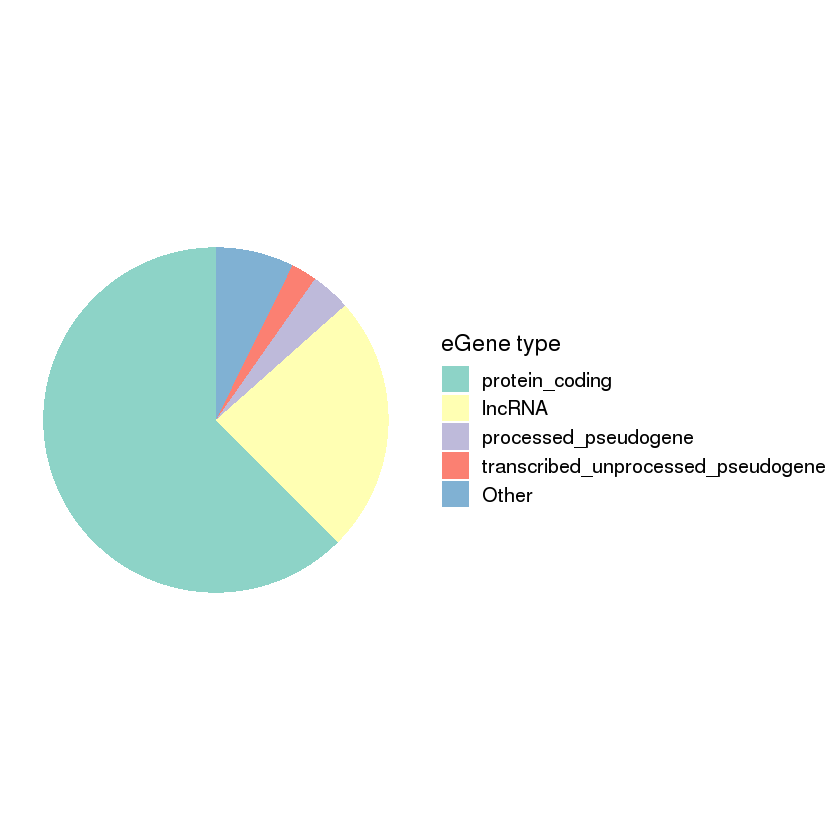

In [61]:
p <- ggplot(df, aes(x="", y=prop, fill=type)) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar("y", start = 0) +
#   geom_text(aes(x="", y=pos, label=percent(prop)), size=4) +
#   facet_wrap(~group) +
  theme_void() +
  theme(legend.text = element_text(size=12),
        legend.title = element_text(size=14)) +
  scale_fill_brewer(palette = "Set3") +
  labs(fill="eGene type")

#   geom_text_repel(aes(x = 1.6, y = pos, label = percent(prop)), 
#                     nudge_x = .3, 
#                     segment.size = .7, 
#                     show.legend = FALSE)
p 

In [56]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/egene_type.png", p, height=4, width=8)

### 8: Conditional cis-eQTL

In [2]:
# this is top variants per rank of all expressed genes
dat <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_conditional_90hcp/conditional_top_variants.txt", hea = F, stringsAsFactors = F)

In [3]:
head(dat)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,ENSG00000225231,12,10096094,10096094,+,5720,-8,rs74065411,12,10096086,10096086,0,3.14265e-94,1.851300,1,1,9.63757e-30,0.986945,1,1
2,ENSG00000225231,12,10096094,10096094,+,5720,26397,rs117342025,12,10122491,10122491,1,4.63615e-07,1.305250,0,1,1.31698e-08,1.467830,1,1
3,ENSG00000225231,12,10096094,10096094,+,5720,431443,chr12:10374938,12,10527537,10527537,2,7.39525e-05,-0.998189,0,0,1.75707e-06,-1.200460,1,1
4,ENSG00000225231,12,10096094,10096094,+,5720,408465,rs11053768,12,10504559,10504559,3,2.28570e-05,-0.226318,1,1,8.50279e-06,-0.237747,1,1
5,ENSG00000225231,12,10096094,10096094,+,5720,20341,rs2961539,12,10116435,10116435,4,1.31384e-05,0.702543,1,1,1.31384e-05,0.702543,1,1
6,ENSG00000173391,12,10324737,10324737,+,6210,-14018,rs34874375,12,10310719,10310719,0,2.72119e-08,-0.116202,1,1,1.15849e-07,-0.276397,1,1


In [4]:
table(dat$V19)
table(dat$V20)


    1 
17566 


    0     1 
   69 17497 

In [10]:
# subset eGenes only
# egene_dat <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_perm_90hcp/sig_pheno.txt",hea = T, stringsAsFactors = F)

In [19]:
# dat <- dat[dat$V1 %in% egene$pid,]

In [5]:
length(unique(dat$V1))

[1] 11630

In [6]:
# remove variants with backward P-value is not below the threshold of this phenotype
dat <- dat %>% filter(V20 == 1)
dim(dat)

[1] 17497    20

**How many ranks/independent QTL each gene has? (+1 because primary QTL is rank 0)**

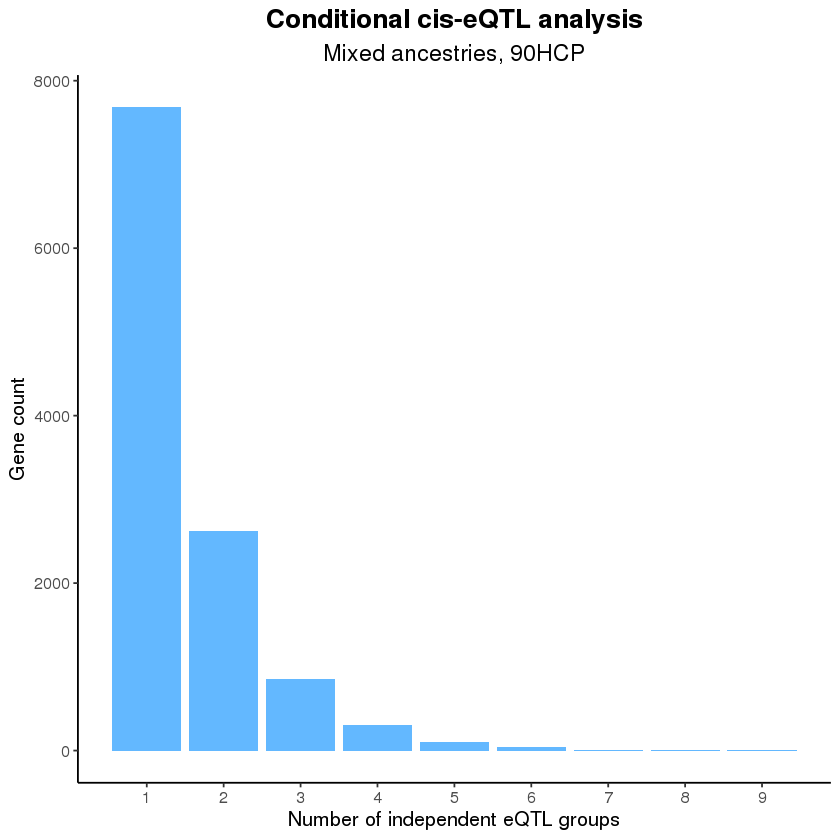

In [8]:
df <- data.frame("gene" <- unique(dat$V1),
                 "num_rank" <- NA)
for (i in 1:nrow(df)) {
  gene <- df[i,1]
  df[i,2] <- max(dat[dat$V1==gene,12]) + 1
}
names(df) <-c("gene","num_rank")

p <- ggplot(df, aes(x=num_rank)) +
  geom_bar(fill="steelblue1") +
  scale_x_continuous(breaks = seq(1,9,by=1)) +
  labs(x="Number of independent eQTL groups", y="Gene count") +
  ggtitle("Conditional cis-eQTL analysis", subtitle = "Mixed ancestries, 90HCP") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))
p

In [9]:
table(dat$V12)


    0     1     2     3     4     5     6     7     8 
11501  3944  1326   469   166    62    19     8     2 

In [10]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/condition_rank.png", height=6, width=6)

**Primary and seconday distance to TSS**

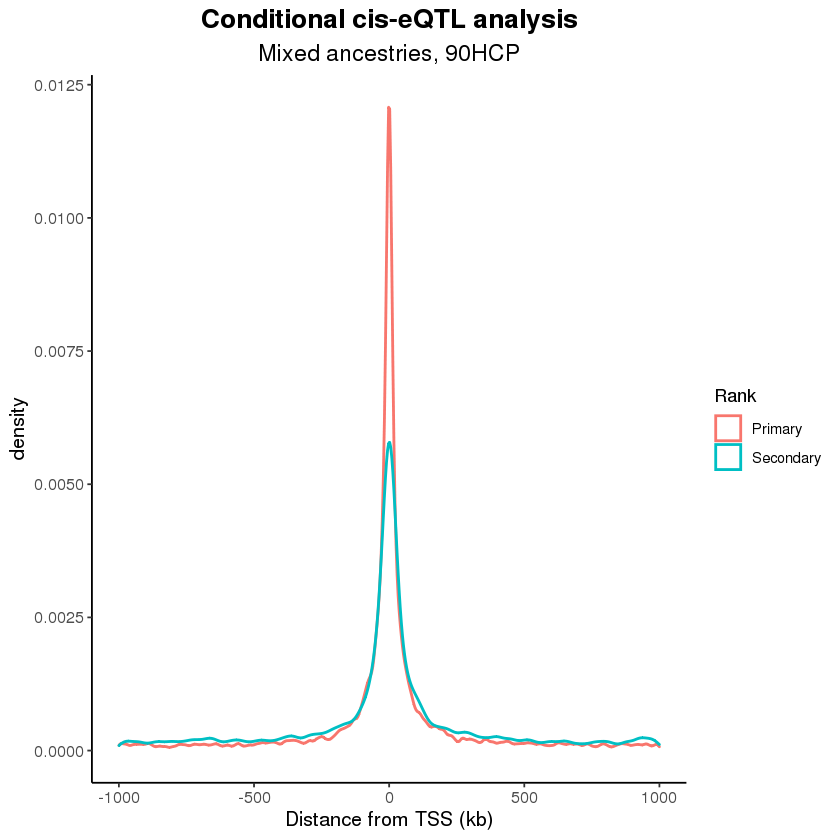

In [11]:
dat2 <- filter(dat,V12 <= 1)
dat2$tss_kb <- dat2$V7/1000

dat2$Rank <- ifelse(dat2$V12==0,"Primary","Secondary")

p2 <- ggplot(dat2, aes(x=tss_kb, color=Rank)) +
  geom_density(size=.8) +
  labs(x="Distance from TSS (kb)") +
  ggtitle("Conditional cis-eQTL analysis", subtitle = "Mixed ancestries, 90HCP") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))
p2

In [12]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/condition_dtss.png", height=6, width=6)